In [25]:
'''
This notebook calculates the distance to splicing and plots panels for Figure 3 and Figure S4
'''

'\nThis notebook calculates the distance to splicing and plots panels for Figure 3 and Figure S4\n'

In [26]:
import os
import re

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import mygene
import scipy

from plotnine import *
import warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42 # export pdfs with editable font types in Illustrator

In [120]:
# Links to input data: BED12 files that have been filtered to remove splicing intermediates
dataFiles = [
    '../1_filter_data/1_untreated_RSII_polyAfiltered_no_7SK_sorted_unique_no_splicing_int.bed',
    '../1_filter_data/1_untreated_SQ_polyAfiltered_no_7SK_sorted_unique_no_splicing_int.bed',
    '../1_filter_data/2_untreated_RSII_polyAfiltered_no_7SK_sorted_unique_no_splicing_int.bed',
    '../1_filter_data/2_untreated_SQ_polyAfiltered_no_7SK_sorted_unique_no_splicing_int.bed',
    '../1_filter_data/3_DMSO_RSII_polyAfiltered_no_7SK_sorted_unique_no_splicing_int.bed',
    '../1_filter_data/3_DMSO_SQ_polyAfiltered_no_7SK_sorted_unique_no_splicing_int.bed',
    '../1_filter_data/4_DMSO_RSII_polyAfiltered_no_7SK_sorted_unique_no_splicing_int.bed',
    '../1_filter_data/4_DMSO_SQ_polyAfiltered_no_7SK_sorted_unique_no_splicing_int.bed',
     ]

dataFiles_nanoCOP = [
    '../1_filter_data/nanoCOP_data/SRR8268942_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR8268943_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR8268944_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR8268945_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR8268946_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR8268947_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR8268948_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR8268949_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR8932660_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR8932661_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR8932662_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR8932663_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR8932664_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR8932665_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR8932666_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR8932667_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR8932668_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR10097603_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR10097604_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR10097605_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR10097606_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR10097607_sorted_unique.bed'
]

# Link to intron annotation to get intron ID from coordinates
introns = pd.read_csv('../annotation_files/mm10_VM20_introns_unique.bed', 
                      delimiter = '\t', 
                      names =  ['chr', 'start', 'end', 'name', 'score', 'strand']) # unique introns, filtered in previous script

introns_all = pd.read_csv('../annotation_files/mm10_VM20_introns.bed.gz', 
                      delimiter = '\t', 
                      names =  ['chr', 'start', 'end', 'name', 'score', 'strand'],
                      compression = 'gzip') # unique introns, filtered in previous script

# Link to SraRunTable.txt experiment info file for nanoCOP data
srainfo = pd.read_csv('../0_mapped_data/nanoCOP/SraRunTable.txt',
                      delimiter = ',',
                      header = 0)

In [28]:
# Get last block size, which is the distance from the last splice junction to the 3'end

def get_dist_to_splicing(file):
    f = open(file)

    output = [] # create an empty list for output to be added to
    
    filestring = file.split('/')[-1].split('_')[0:3]
    sample = '_'.join(filestring) # get sample ID from file name
    
    for line in f:
        line_split = line.split('\t')
        exon_size_list = line_split[10] # gets list of block (exon) sizes from BED12 file
        intron_size_list = line_split[11] # gets list of block starts
        strand = line_split[5]
        n_blocks = int(line_split[9])
        chr = line_split[0]
        exon_size = exon_size_list.split(",")
        intron_size = intron_size_list.split(",")
        
        if n_blocks > 1: # for spliced reads only...
            last_intron_size_plus = str(int(intron_size[-1]) - int(intron_size[-2]) - int(exon_size[-2]))
            last_intron_size_minus = str(int(intron_size[1]) - int(exon_size[0]))
           
            if strand == '+':
                read_end = line_split[2]
                upstream_intron_start_plus = (int(read_end) - int(exon_size[-1]) - int(last_intron_size_plus))
                upstream_intron_end_plus = (int(read_end) - int(exon_size[-1]))
                output.append([exon_size[-1], last_intron_size_plus, chr, str(upstream_intron_start_plus), str(upstream_intron_end_plus), str(strand), sample])

            if strand == '-':
                read_end = line_split[1]
                upstream_intron_end_minus = (int(read_end) + int(exon_size[0]))
                upstream_intron_start_minus = (int(read_end) + int(exon_size[0]) + int(last_intron_size_minus))
                output.append([exon_size[0], last_intron_size_minus, chr, str(upstream_intron_end_minus), str(upstream_intron_start_minus), str(strand), sample])
    
    df = pd.DataFrame(output, columns=['dist_to_splicing', 'upstream_intron_length', 'chr', 'start', 'end', 'strand', 'sample'])
    return df

In [29]:
# Get last block size for nanoCOP data, which is the distance from the last splice junction to the 3'end
# only difference for this from the pacbio data is getting the sample name from the filestring

def get_dist_to_splicing_nanoCOP(file):
    f = open(file)

    output = [] # create an empty list for output to be added to
    
    sample = file.split('/')[-1].split('_')[0] # get sample ID from file name
    
    for line in f:
        line_split = line.split('\t')
        exon_size_list = line_split[10] # gets list of block (exon) sizes from BED12 file
        intron_size_list = line_split[11] # gets list of block starts
        strand = line_split[5]
        n_blocks = int(line_split[9])
        chr = line_split[0]
        exon_size = exon_size_list.split(",")
        intron_size = intron_size_list.split(",")
        
        if n_blocks > 1: # for spliced reads only...
            last_intron_size_plus = str(int(intron_size[-1]) - int(intron_size[-2]) - int(exon_size[-2]))
            last_intron_size_minus = str(int(intron_size[1]) - int(exon_size[0]))
           
            if strand == '+':
                read_end = line_split[2]
                upstream_intron_start_plus = (int(read_end) - int(exon_size[-1]) - int(last_intron_size_plus))
                upstream_intron_end_plus = (int(read_end) - int(exon_size[-1]))
                output.append([exon_size[-1], last_intron_size_plus, chr, str(upstream_intron_start_plus), str(upstream_intron_end_plus), str(strand), sample])

            if strand == '-':
                read_end = line_split[1]
                upstream_intron_end_minus = (int(read_end) + int(exon_size[0]))
                upstream_intron_start_minus = (int(read_end) + int(exon_size[0]) + int(last_intron_size_minus))
                output.append([exon_size[0], last_intron_size_minus, chr, str(upstream_intron_end_minus), str(upstream_intron_start_minus), str(strand), sample])
    
    df = pd.DataFrame(output, columns=['dist_to_splicing', 'upstream_intron_length', 'chr', 'start', 'end', 'strand', 'sample'])
    return df

In [30]:
# Calculate distance to splicing for all PacBio samples and combine output in one dataframe
df_list = []
for file in dataFiles:
    df_list.append(get_dist_to_splicing(file))
    
df = pd.concat(df_list)

df['dist_to_splicing'] = df['dist_to_splicing'].astype('int')
df['upstream_intron_length'] = df['upstream_intron_length'].astype('int') # convert calculated distances to integers

In [31]:
# Calculate distance to splicing for all nanoCOP samples and combine output in one dataframe
df_list_nanoCOP = []
for file in dataFiles_nanoCOP:
    df_list_nanoCOP.append(get_dist_to_splicing_nanoCOP(file))
    
df_nanoCOP = pd.concat(df_list_nanoCOP)

df_nanoCOP['dist_to_splicing'] = df_nanoCOP['dist_to_splicing'].astype('int')
df_nanoCOP['upstream_intron_length'] = df_nanoCOP['upstream_intron_length'].astype('int') # convert calculated distances to integers

In [32]:
# Describe dataframe basic statistics
dist_stats = df.describe()
dist_stats

,dist_to_splicing,upstream_intron_length
count,168567.000000,168567.000000
mean,278.820161,4565.427361
std,373.265527,17026.447937
min,7.000000,30.000000
25%,75.000000,266.000000
50%,142.000000,875.000000
75%,306.000000,2451.000000
max,6010.000000,376961.000000


In [33]:
# Describe nanoCOP dataframe basic statistics
dist_stats_nanoCOP = df_nanoCOP.describe()
dist_stats_nanoCOP

,dist_to_splicing,upstream_intron_length
count,292182.000000,292182.000000
mean,509.544264,6055.951397
std,568.628022,23777.493205
min,6.000000,30.000000
25%,137.000000,107.000000
50%,311.000000,554.000000
75%,686.000000,2143.000000
max,9731.000000,509391.000000


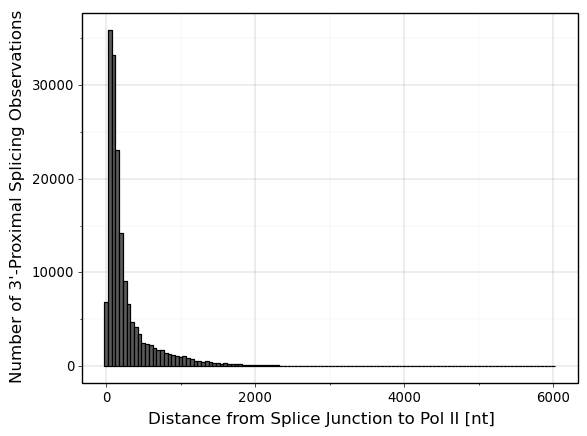

<ggplot: (8788394885477)>

In [34]:
# Plot distribution of distances to splicing
dist_to_splicing_hist = (ggplot
     (data = df, mapping = aes(x = 'dist_to_splicing')) + 
      geom_histogram(binwidth = 50, position = 'stack', alpha = 1, colour = 'black') +
      theme_linedraw(base_size = 12) +
      xlab('Distance from Splice Junction to Pol II [nt]') +
      ylab("Number of 3'-Proximal Splicing Observations")
    )

dist_to_splicing_hist #NOTE: data is not normally distributed

In [35]:
# For nanoCOP samples, match accession ID to cell type using SraRunTable.txt experiment info file
df_nanoCOP_merged = pd.merge(df_nanoCOP, srainfo[['Run','source_name', 'cell_treatment']], left_on = 'sample', right_on = 'Run', how = 'left')
df_nanoCOP_merged = df_nanoCOP_merged.drop(columns = ['Run'])

# for MEL samples, add MEL as 'source_name'
df['source_name'] = 'MEL cells'

# For MEL samples, group uninduced and induced samples together, create 'cell_treatment' column
df['sample'] = df['sample'].astype('string')
df['cell_treatment'] = pd.np.where(df['sample'].str.contains("untreated"), "Uninduced", "Induced") # group by uninduced or DMSO string in sample name
cat_type = CategoricalDtype(categories=['Uninduced', 'Induced'], ordered=True) # turn group column into a category variable in order to control order of plotting

df['cell_treatment'] = df['cell_treatment'].astype(cat_type)

# combined pacbio and nanoCOP df's so they can be plotted together
df_all = pd.concat([df, df_nanoCOP_merged])

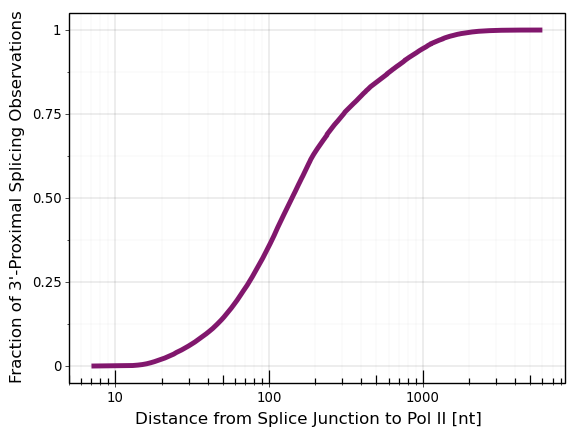

<ggplot: (8788396084961)>

In [36]:
# Plot cumulative frequency plot of distances to splicing

plot_ecdf = (ggplot
#      (data = df, mapping = aes(x = 'dist_to_splicing', colour = 'sample')) + 
     (data = df, mapping = aes(x = 'dist_to_splicing')) + 
#       geom_histogram(binwidth = .1, position = 'stack', alpha = 1, colour = 'black') +
      theme_linedraw(base_size = 12) +
      stat_ecdf(geom = 'smooth', size = 2, color = '#81176D') +
      xlab('Distance from Splice Junction to Pol II [nt]') +
      ylab("Fraction of 3'-Proximal Splicing Observations") +
      scale_x_log10() +
      annotation_logticks(sides = "b") 
    )

plot_ecdf

In [37]:
len(df.loc[df['cell_treatment'] == 'Uninduced'])

101911

In [38]:
len(df.loc[df['cell_treatment'] == 'Induced'])

66656

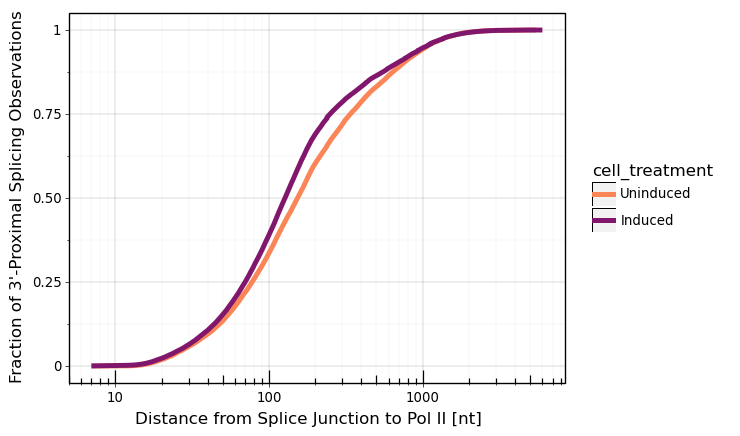

<ggplot: (8788396012309)>

In [39]:
# Plot the same as above, but separated by uninduced/induced treatment
plot_ecdf_treatment = (ggplot
     (data = df, mapping = aes(x = 'dist_to_splicing', colour = 'cell_treatment')) + 
#       geom_histogram(binwidth = .1, position = 'stack', alpha = 1, colour = 'black') +
      theme_linedraw(base_size = 12) +
      stat_ecdf(geom = 'smooth', size = 2) +
      xlab('Distance from Splice Junction to Pol II [nt]') +
      ylab("Fraction of 3'-Proximal Splicing Observations") +
      scale_colour_manual(values = ['#FA8657', '#81176D']) +
      scale_x_log10() +
      annotation_logticks(sides = "b") 
    )

plot_ecdf_treatment

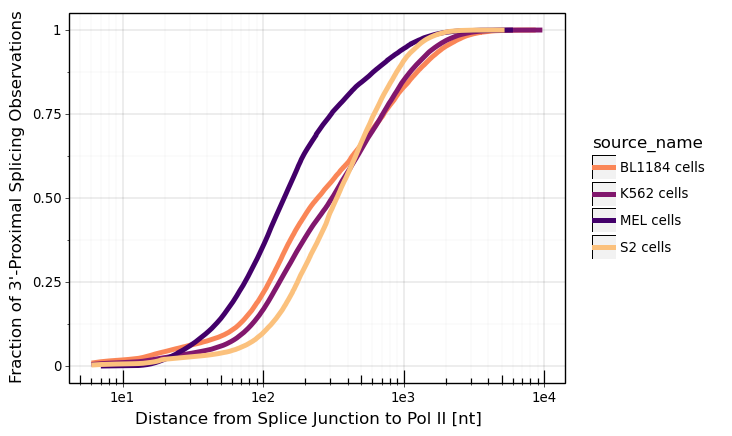

<ggplot: (8788396040721)>

In [40]:
# Plot distances to splicing for Drexler et al. nanoCOP data alongside MEL data
plot_ecdf_nanoCOP = (ggplot
     (data = df_all, mapping = aes(x = 'dist_to_splicing', colour = 'source_name')) + 
#       geom_histogram(binwidth = .1, position = 'stack', alpha = 1, colour = 'black') +
      theme_linedraw(base_size = 12) +
      stat_ecdf(geom = 'smooth', size = 2) +
      xlab('Distance from Splice Junction to Pol II [nt]') +
      ylab("Fraction of 3'-Proximal Splicing Observations") +
      scale_colour_manual(values = ['#FA8657', '#81176D', '#43006A', '#FBC17D']) +
      scale_x_log10() +
      annotation_logticks(sides = "b") 
    )

plot_ecdf_nanoCOP

In [41]:
# Group distance to splicing by cell type and summarize
tbl_dist_cell = df_all.groupby('source_name')['dist_to_splicing'].describe()
tbl_dist_cell

,count,mean,std,min,25%,50%,75%,max
source_name,,,,,,,,
BL1184 cells,39397.0,543.100414,700.068735,6.0,111.0,244.0,723.0,8719.0
K562 cells,183829.0,522.658830,591.260241,6.0,131.0,310.0,711.0,9731.0
MEL cells,168567.0,278.820161,373.265527,7.0,75.0,142.0,306.0,6010.0
S2 cells,68956.0,455.410479,392.502796,6.0,176.0,335.0,617.0,5237.0


p-value short vs. med = 0.3821168862869348
p-value med vs. long = 3.8571327125552825e-62


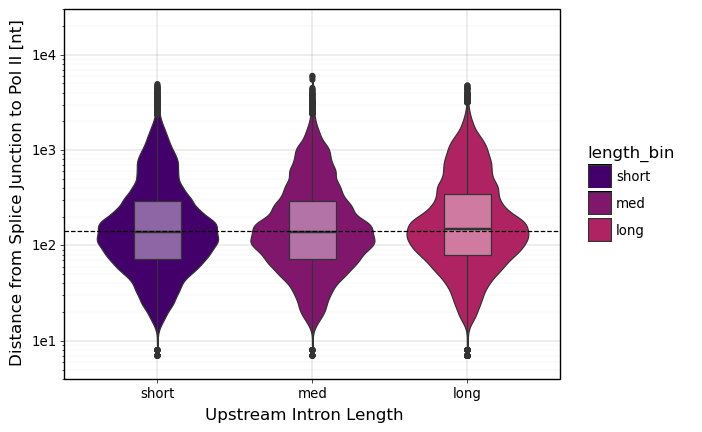

<ggplot: (8788395838101)>

In [42]:
# Plot distance to splicing vs. upstream intron length
# cut upstream intron length into bins to make violin plots
df['length_bin'] = pd.qcut(df['upstream_intron_length'], 3, labels = ['short', 'med', 'long'])

median = df['dist_to_splicing'].median()
my_colours = ['#43006A', '#81176D', '#B02363']

# r_value, p_value = scipy.stats.pearsonr(df['dist_to_splicing'], y = df['upstream_intron_length'])
# print('R-value: ' + str(r_value))
# print('p-value: ' + str(p_value))

plot_up_intron_length = (ggplot
      (data = df, mapping = aes(x = 'length_bin', y = 'dist_to_splicing', fill = 'length_bin')) +
      geom_violin(width = 0.8) +
      geom_boxplot(width = 0.3, fill = 'white', alpha = 0.4) +
      geom_abline(intercept = np.log10(median), slope = 0, colour = 'black', linetype = 'dashed') +
      theme_linedraw(base_size = 12) +
      ylab('Distance from Splice Junction to Pol II [nt]') +
      xlab('Upstream Intron Length') +
      scale_y_log10() +
      scale_y_log10(limits = (6,20000)) +
      scale_fill_manual(values = my_colours)
    )

# make df of different length bins for statistical test
short = df[df['length_bin'] == 'short']
med = df[df['length_bin'] == 'med']
long = df[df['length_bin'] == 'long']
# calculate p-values between protein-coding and two non-coding category with MWU test
p_short_med = scipy.stats.mannwhitneyu(short['dist_to_splicing'], med['dist_to_splicing'])[1]
p_med_long = scipy.stats.mannwhitneyu(med['dist_to_splicing'], long['dist_to_splicing'])[1]

print('p-value short vs. med = ' + str(p_short_med))
print('p-value med vs. long = ' + str(p_med_long))
plot_up_intron_length

In [35]:
# Plot 3' end positions relative to end of downstream exon

In [145]:
# add two columns to introns: txid from name and length from start-end coords
### NOTE: here we must start with the file that contains all introns, not just unique ones, because we need information about the downstrema intron in each transcript
introns_all['txid'] = introns_all.name.str.split('_').str[0]

# add a column for intron length ###NOTE: check this for 0- or 1- based arithmetic errors!!!
introns_all['length'] = abs(introns_all['end'] - introns_all['start']) + 1

# remove rows at the end of the file that are contain chrUn and chr1_GL456210_random
introns_all = introns_all[~introns_all.chr.str.contains("_")] # both of these contain a '_' in the chr column

In [146]:
# For each intron, get coordinates for next downstream intron in the same transcript
# split intron file by strand becuase intron rank is opposite for each strand
is_forward_intron = introns_all['strand'] == '+' # filter only introns that are on the + strand
forward_introns = introns_all[is_forward_intron]
is_reverse_intron = introns_all['strand'] == '-' # filter only introns that are on the - strand
reverse_introns = introns_all[is_reverse_intron]

# get information about downstream intron for forward introns
forward_introns.sort_values(by=['name']) # sort by intron name which puts transcripts and then introns in order
nameSplitf = forward_introns['name'].str.split("_", expand = True) #split name column to get txid and intron rank information
forward_introns['intron_rank'] = nameSplitf[2].astype(float)
forward_introns['next_intron_name'] = forward_introns['name'].shift(-1) # new column write the name of the intron in the next row (next intron if available)
nextIntronSplitf = forward_introns['next_intron_name'].str.split("_", expand = True)
forward_introns['next_intron_txid'] = nextIntronSplitf[0]
forward_introns['next_intron_rank'] = nextIntronSplitf[2].astype(float)
forward_introns['next_intron_end'] = forward_introns['end'].shift(-1) # next intron end coordinates

# get information about downstream intron for reverse introns
reverse_introns.sort_values(by=['name']) # sort by intron name which puts transcripts and then introns in order
nameSplitr = reverse_introns['name'].str.split("_", expand = True) #split name column to get txid and intron rank information
reverse_introns['intron_rank'] = nameSplitr[2].astype(float)
reverse_introns['next_intron_name'] = reverse_introns['name'].shift(1) # new column write the name of the intron in the next row (next intron if available)
nextIntronSplitr = reverse_introns['next_intron_name'].str.split("_", expand = True)
reverse_introns['next_intron_txid'] = nextIntronSplitr[0]
reverse_introns['next_intron_rank'] = nextIntronSplitr[2].astype(float)
reverse_introns['next_intron_end'] = reverse_introns['end'].shift(1) # next intron end coordinates

In [147]:
# mark that the next intron is in the same transcript for forward introns
forward_introns['paired'] = np.where((forward_introns['txid'] == forward_introns['next_intron_txid'])
                                & (forward_introns['next_intron_rank'] == (forward_introns['intron_rank'] + 1)),
                                'YES', 'NO') # check if transcript name is the same and intron rank is one more in downstream intron

# mark that the next intron is in the same transcript reverse introns
reverse_introns['paired'] = np.where((reverse_introns['txid'] == reverse_introns['next_intron_txid'])
                                & (reverse_introns['next_intron_rank'] == (reverse_introns['intron_rank'] - 1)),
                                'YES', 'NO') # check if transcript name is the same and intron rank is one less in downstream intron

# keep only introns which are paired with a downstream intron (gets rid of single-intron transcripts and last introns)
forward_introns = forward_introns[forward_introns['paired'] == 'YES']
reverse_introns = reverse_introns[reverse_introns['paired'] == 'YES']

In [148]:
# get coordinate information for downstream intron
forward_introns['next_intron_chr'] = nextIntronSplitf[4]
forward_introns['next_intron_start'] = nextIntronSplitf[5].astype(float)
forward_introns['start'] = forward_introns['start'].astype(float)
forward_introns['end'] = forward_introns['end'].astype(float)
forward_introns['next_intron_start'] = (forward_introns['next_intron_start'] - 1)

reverse_introns['next_intron_chr'] = nextIntronSplitr[4]
reverse_introns['next_intron_start'] = nextIntronSplitr[5].astype(float)
reverse_introns['start'] = reverse_introns['start'].astype(float)
reverse_introns['end'] = reverse_introns['end'].astype(float)
reverse_introns['next_intron_start'] = (reverse_introns['next_intron_start'] - 1)

In [149]:
# recombine + and - strand introns, and calculate length of downstream exon for each
introns_final = pd.concat([forward_introns, reverse_introns], axis=0)

introns_final['length_ds_exon'] = np.where((introns_final['strand'] == '+'),
                                     (introns_final['next_intron_start'] - introns_final['end']),
                                     (introns_final['start'] - introns_final['next_intron_end']))

In [150]:
# At this point, there are multiple transcripts that contain each intron, and it is unclear which transcript each read should be assinged to
# So, group introns_final by the intron in question, then keep that group only if the downstrem intron is unambigous among the possible transcripts

g = introns_final.groupby(['chr', 'start', 'end', 'strand', 'length_ds_exon'])
test = g.first()
test = test.reset_index()

In [151]:
test_nodup = test.drop_duplicates(subset = ['chr', 'start', 'end', 'strand'], keep = False)

In [152]:
# group by first intron and downstream exon size
# keep first in each group
# remove any duplicate first introns - which would mean they have more than one possible downstream exon size

In [153]:
# merge distance_to_splicing data with introns to match each SJ with information about length of downstream exon
df['start'] = df['start'].astype(float)
df['end'] = df['end'].astype(float)

data = pd.merge(df, test_nodup, how = 'left', left_on = ['chr', 'start', 'end', 'strand'], right_on = ['chr', 'start', 'end', 'strand'])

In [154]:
# get relative distance between SJ and downstream exon end
data['dist'] = data['dist_to_splicing'].astype(float)
data['rel_dist'] = data['dist_to_splicing'] - data['length_ds_exon']

# drop any rows that did not get matched up with an intron
data = data.dropna(axis = 0, how = 'any')

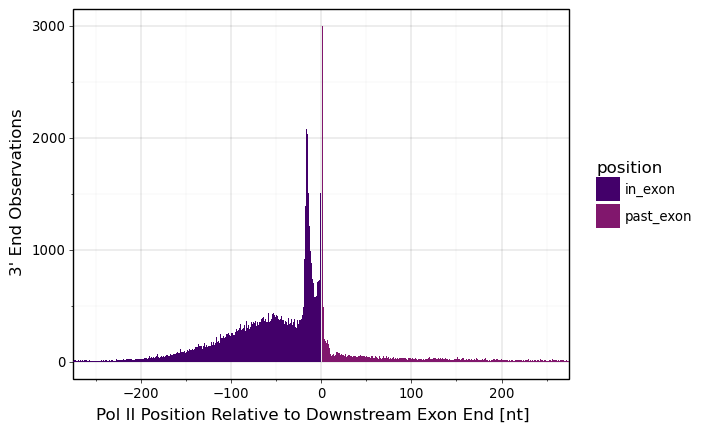

<ggplot: (8788130539269)>

In [155]:
# plot relative distances, which are centered around the downstream exon end

# add new column to colour histogram based on upstream or downstream of exon
data['position'] = np.where((data['rel_dist'] < 0),'in_exon', 'past_exon') # check if transcript name is the same and intron rank is one more in downstream intron

plt_dist_rel_dsexon = (ggplot
       (data = data, mapping = aes(x = 'rel_dist', fill = 'position')) + 
#         geom_density(kernel = 'gaussian', colour = '#81176D', size = 1) +
        geom_histogram(binwidth = 1) +
        coord_cartesian(xlim = (-250,250)) +
        xlab("Pol II Position Relative to Downstream Exon End [nt]") +
        ylab("3' End Observations") +
        theme_linedraw(base_size = 12) +
        scale_fill_manual(values = my_colours)
)

plt_dist_rel_dsexon

In [156]:
# calculate number of 3'ends that are within downstream exon and past downstream exon
within_exon = data['rel_dist'] < 0
intron_def = data[within_exon]

past_exon = data['rel_dist'] > 0
exon_def = data[past_exon]

# fraction of data that supports intron definition
indef = len(intron_def.index) / len(data.index)

# fraction of data that supports exon definition
exdef = len(exon_def.index) / len(data.index)

print('Fraction of intron defintion reads: ' + str(indef))
print('Fraction of exon defintion reads: ' + str(exdef))
print('Total number of observations: ' + str(len(data.index)))

Fraction of intron defintion reads: 0.7627311728918729
Fraction of exon defintion reads: 0.2372688271081271
Total number of observations: 82514


In [157]:
# Save outputs
dist_to_splicing_hist.save('distance_to_splicing_histogram.pdf')
plot_ecdf.save('distance_to_splicing_ecdf.pdf')
plot_ecdf_treatment.save('distance_to_splicing_by_treatment_ecdf.pdf')
plot_ecdf_nanoCOP.save('distance_to_splicing_with_nanoCOP.pdf')
plot_up_intron_length.save('distance_to_splicing_upstream_intron_length.pdf')
plt_dist_rel_dsexon.save('distance_to_splicing_downstream_exon.pdf')

dist_stats.to_csv('distance_to_splicing_summary_stats.csv', 
               sep = '\t', 
               index = True, 
               header = True)